###Import Libraries and Set Constants

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50




###Clone the Dataset Repository

In [ ]:
!git clone https://github.com/ramy-arab/potato-disease-classification.git


Cloning into 'potato-disease-classification'...
remote: Enumerating objects: 2161, done.
remote: Counting objects: 100% (2161/2161), done.
remote: Compressing objects: 100% (2160/2160), done.
remote: Total 2161 (delta 0), reused 2161 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (2161/2161), 37.36 MiB | 21.24 MiB/s, done.


###Load Dataset and Display Class Names

In [ ]:
# Load dataset and preprocess images

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/potato-disease-classification/dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names
class_names = dataset.class_names
print("Class Names:", class_names)


Found 2152 files belonging to 3 classes.
Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


###Dataset Splitting

In [ ]:
# Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


###Optimizing Performance with Prefetching

In [ ]:
# Prefetch and Optimize Performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


###Data Augmentation Pipeline

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example of ImageDataGenerator with aggressive augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=40,       # Random rotations between 0 and 40 degrees
    width_shift_range=0.2,   # Random horizontal translations
    height_shift_range=0.2,  # Random vertical translations
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zooms
    #horizontal_flip=True,    # Randomly flip images horizontally
    #fill_mode='nearest'      # Fill missing pixels with nearest value
)


###Squeeze-and-Excitation (SE) Block Definition

In [ ]:
# Define the Squeeze-and-Excitation (SE) Block
def squeeze_excite_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([input_tensor, se])


###Model Architecture with Attention Mechanism (SE Block)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def build_model():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # Define input shape here

    # Aggressive data augmentation
    x = layers.RandomRotation(0.2)(inputs)  # Rotation
    x = layers.RandomZoom(0.2)(x)  # Zoom
    x = layers.RandomWidth(0.2)(x)  # Random width shift
    x = layers.RandomHeight(0.2)(x)  # Random height shift
    x = layers.RandomTranslation(height_factor=0.2, width_factor=0.2)(x)  # Translation as an alternative
    x = layers.RandomFlip("horizontal")(x)  # Horizontal flip
    x = layers.Rescaling(1./255)(x)  # Normalize images

    # First Conv Block with L2 Regularization, Dropout, and SE Block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = squeeze_excite_block(x)  # Apply SE block

    # Second Conv Block with L2 Regularization, Dropout, and SE Block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = squeeze_excite_block(x)  # Apply SE block

    # Third Conv Block with L2 Regularization, Dropout, and SE Block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)
    x = squeeze_excite_block(x)  # Apply SE block

    # Fourth Conv Block with L2 Regularization, Dropout, and SE Block
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)
    x = squeeze_excite_block(x)  # Apply SE block

    # Use Global Average Pooling to resolve the shape issue
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected (Dense) Layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout to avoid overfitting
    outputs = layers.Dense(len(dataset.class_names), activation='softmax')(x)  # Output layer

    # Create the model
    model = models.Model(inputs, outputs)
    return model




# Build and compile the model
model = build_model()

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation           │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom (RandomZoom)  │ (None, 256, 256, 3)    │              0 │ random_rotation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_width              │ (None, 256, None, 3)   │              0 │ random_zoom[0][0]      │
│ (RandomWidth)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_height             │ (None, None, None, 3)  │              0 │ random_width[0][0]     │
│ (RandomHeight)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_translation        │ (None, None, None, 3)  │              0 │ random_height[0][0]    │
│ (RandomTranslation)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip (RandomFlip)  │ (None, None, None, 3)  │              0 │ random_translation[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ random_flip[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            896 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 32) │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, None, None, 32) │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ dropout[0][0]          │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │             96 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, None, None, 32) │              0 │ dropout[0][0],         │
│                           │                        │                │ reshape[0][0]          │
├──────────────────────

 Total params: 433,089 (1.65 MB)

 Trainable params: 433,089 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

###Train the Model

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


# Train the Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4718 - loss: 3.8877
Epoch 1: val_loss improved from inf to 3.20226, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.4718 - loss: 3.8833 - val_accuracy: 0.5000 - val_loss: 3.2023 - learning_rate: 1.0000e-04
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4445 - loss: 3.0290
Epoch 2: val_loss improved from 3.20226 to 2.61263, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.4446 - loss: 3.0262 - val_accuracy: 0.4792 - val_loss: 2.6126 - learning_rate: 1.0000e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4850 - loss: 2.4868
Epoch 3: val_loss improved from 2.61263 to 2.14653, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.4847 - loss: 2.4847 - val_accuracy: 0.4688 - val_loss: 2.1465 - learning_rate: 1.0000e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4697 - 

###Evaluate the Model on Test Data

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8871 - loss: 0.2928
Test accuracy: 0.8879310488700867


###Plot Training and Validation Accuracy

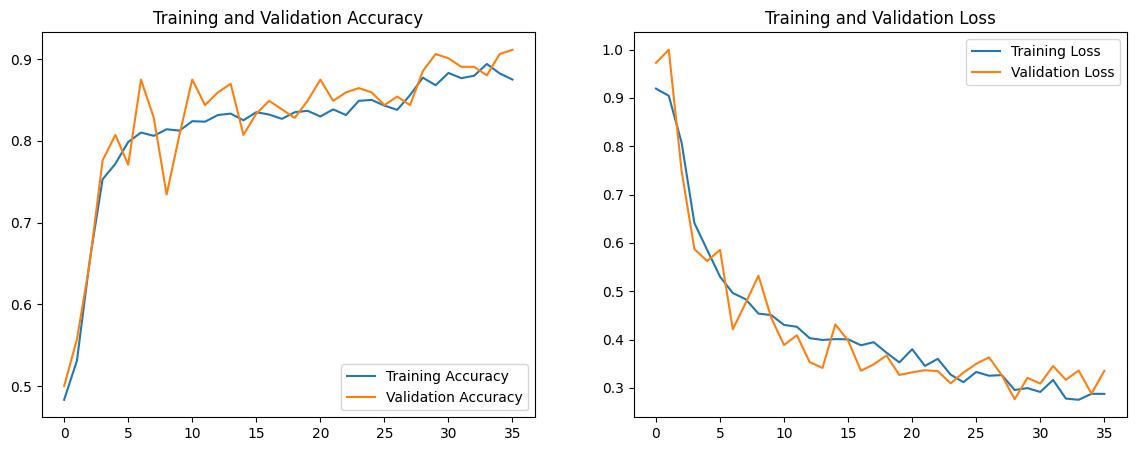

In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt

def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_performance(history)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Prediction accuracy on test dataset: 0.44


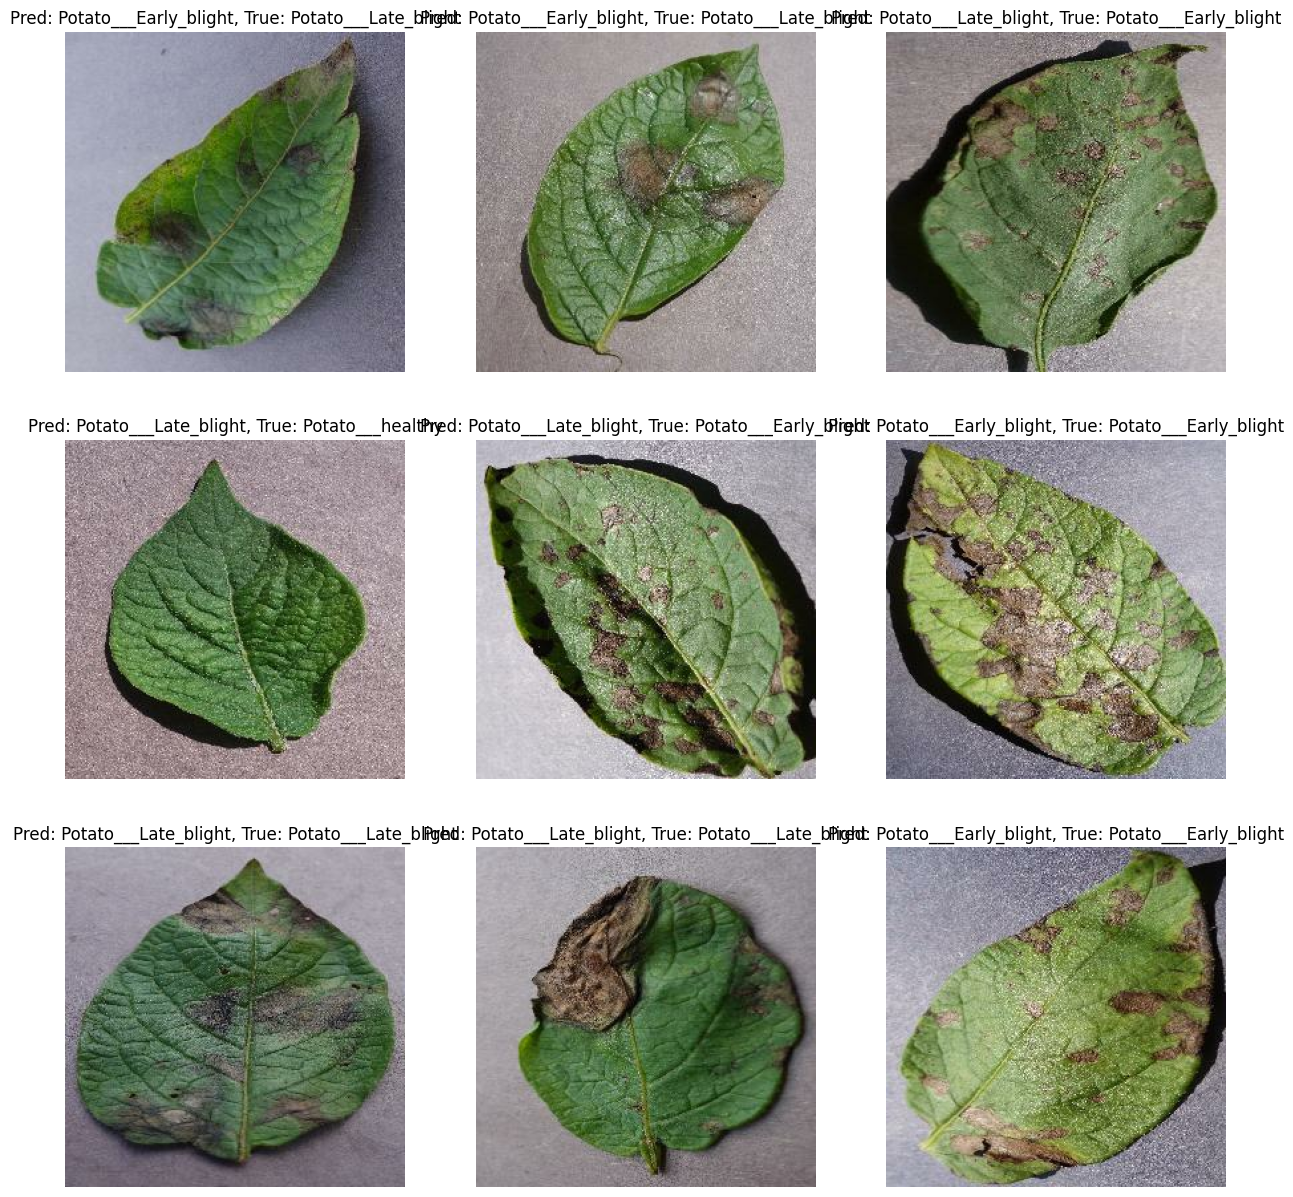

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Make predictions on the test dataset
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate accuracy
accuracy = np.sum(predicted_classes == true_labels) / len(true_labels)
print(f"Prediction accuracy on test dataset: {accuracy:.2f}")

# Display a few predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):  # Take one batch of test images
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_class = class_names[predicted_classes[i]]
        true_class = class_names[labels[i]]
        plt.title(f"Pred: {pred_class}, True: {true_class}")
        plt.axis("off")
plt.show()
